In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/study/group-HW-fraud/financial_loan.csv")

Mounted at /content/drive


In [ ]:
df.isnull().sum()

,0
id,0
address_state,0
application_type,0
emp_length,0
emp_title,1438
grade,0
home_ownership,0
issue_date,0
last_credit_pull_date,0
last_payment_date,0


# Анализ корреляции

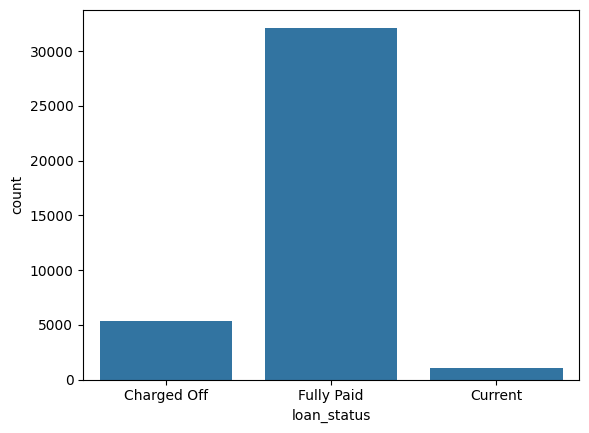

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['loan_status'])
plt.show()

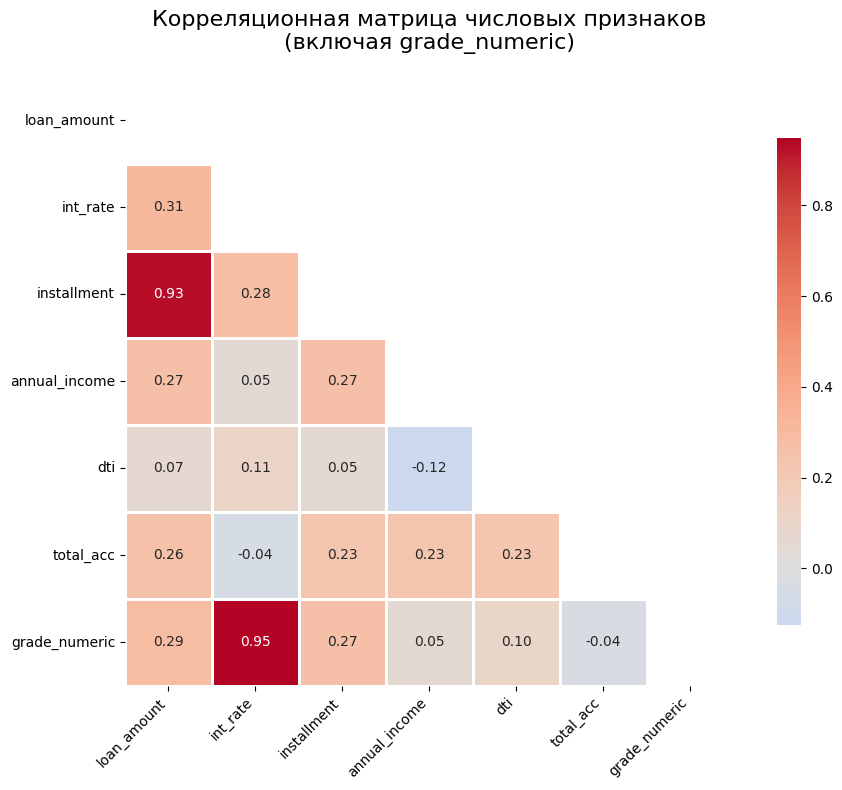

АНАЛИЗ КОРРЕЛЯЦИИ grade_int_rate:
Корреляция между grade_numeric и int_rate: 0.948
✅ ОЧЕНЬ СИЛЬНАЯ корреляция (ожидаемо - это риск-рейтинг)


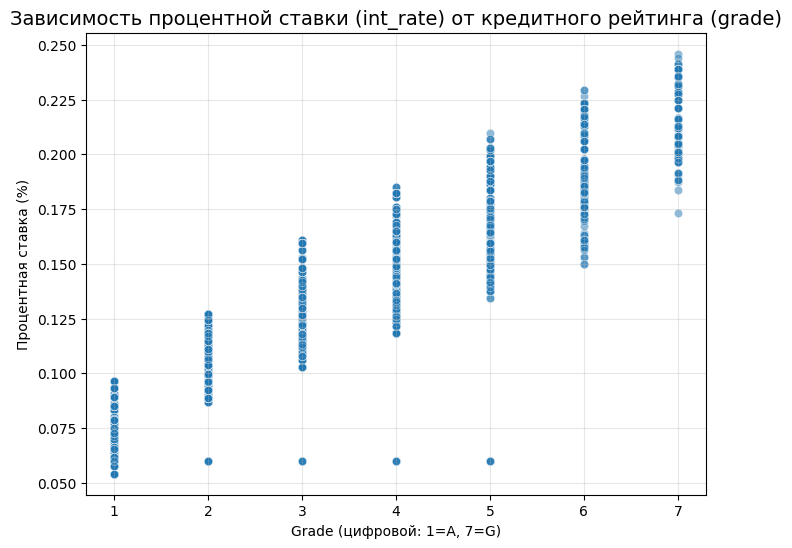


ТОП-5 самых высоких корреляций (по абсолютному значению):
1. int_rate ↔ grade_numeric: 0.948
2. grade_numeric ↔ int_rate: 0.948
3. installment ↔ loan_amount: 0.930
4. loan_amount ↔ installment: 0.930
5. loan_amount ↔ int_rate: 0.308


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Преобразование grade в числовой формат для корреляции
# Создаем словарь для маппинга grade A=1, B=2, C=3, D=4, E=5, F=6, G=7
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade_numeric'] = df['grade'].map(grade_mapping)

# 2. Выбор числовых признаков для анализа корреляции
# Основные числовые признаки из датасета
numerical_features = [
    'loan_amount',
    'int_rate',
    'installment',
    'annual_income',
    'dti',
    'total_acc',
    'grade_numeric'  # преобразованный grade
]

# 3. Создание поднабора данных только с числовыми признаками
correlation_df = df[numerical_features].copy()

# 4. Расчет корреляционной матрицы
correlation_matrix = correlation_df.corr()

# 5. Визуализация heatmap
plt.figure(figsize=(10, 8))

# Создаем маску для верхнего треугольника (чтобы не дублировать)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Строим heatmap с аннотациями
sns.heatmap(correlation_matrix,
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Корреляционная матрица числовых признаков\n(включая grade_numeric)', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Дополнительно: вывод конкретной корреляции grade_int_rate
print("="*60)
print("АНАЛИЗ КОРРЕЛЯЦИИ grade_int_rate:")
print("="*60)
grade_int_corr = correlation_matrix.loc['grade_numeric', 'int_rate']
print(f"Корреляция между grade_numeric и int_rate: {grade_int_corr:.3f}")

# Интерпретация
if abs(grade_int_corr) > 0.7:
    print("ОЧЕНЬ СИЛЬНАЯ корреляция (ожидаемо - это риск-рейтинг)")
elif abs(grade_int_corr) > 0.5:
    print("СИЛЬНАЯ корреляция")
elif abs(grade_int_corr) > 0.3:
    print("УМЕРЕННАЯ корреляция")
else:
    print("СЛАБАЯ корреляция")

# 7. Визуализация связи grade_int_rate (дополнительный scatter plot)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='grade_numeric', y='int_rate', alpha=0.5)
plt.title('Зависимость процентной ставки (int_rate) от кредитного рейтинга (grade)', fontsize=14)
plt.xlabel('Grade (цифровой: 1=A, 7=G)')
plt.ylabel('Процентная ставка (%)')
plt.grid(True, alpha=0.3)
plt.show()

# 8. Вывод топ-5 самых высоких корреляций
print("\n" + "="*60)
print("ТОП-5 самых высоких корреляций:")
print("="*60)

# Преобразуем матрицу корреляций в плоский формат
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False, key=abs)

# Убираем корреляции с собой (равные 1) и дубликаты
corr_pairs = corr_pairs[corr_pairs != 1]
corr_pairs = corr_pairs[~corr_pairs.index.duplicated(keep='first')]

# Выводим топ-5
for i, ((feature1, feature2), corr_value) in enumerate(corr_pairs.head(5).items(), 1):
    print(f"{i}. {feature1} ↔ {feature2}: {corr_value:.3f}")

Обнаружены две пары сильно коррелирующих признаков:
а) int_rate и grade_numeric (|r|≈0.95) (что логично, тк рейтинг заемщика зависит от его способности выплачивать предыдущие кредиты),
б) installment и loan_amount (|r|≈0.93) (чем больше сумма кредита, тем больше ежемесячный платеж).

 Для снижения мультиколлинеарности в линейных моделях и повышения интерпретируемости рассматриваем удаление одного признака из каждой пары (например, исключаем installment, а также используем либо grade/sub_grade, либо int_rate).

# Препроцессинг

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 0) Оставляем только Fully Paid / Charged Off и делаем таргет
df = df[df["loan_status"].isin(["Fully Paid", "Charged Off"])].copy()
df["target"] = (df["loan_status"] == "Charged Off").astype(int)

# 1) Удаляем leakage + идентификаторы + таргет-строку
leakage_cols = [
    "total_payment", "last_payment_date", "next_payment_date", "last_credit_pull_date"
]
id_cols = ["id", "member_id"]

drop_cols = [c for c in leakage_cols + id_cols + ["loan_status"] if c in df.columns]
df = df.drop(columns=drop_cols)

# 2) Детерминированные преобразования
# 2.1 term -> число месяцев
if "term" in df.columns:
    df["term"] = df["term"].astype(str).str.extract(r"(\d+)")[0].astype(float)

# 2.2 emp_length -> число лет
emp_length_map = {
    "< 1 year": 0.5, "1 year": 1, "2 years": 2, "3 years": 3, "4 years": 4,
    "5 years": 5, "6 years": 6, "7 years": 7, "8 years": 8, "9 years": 9,
    "10+ years": 10
}
if "emp_length" in df.columns:
    df["emp_length_num"] = df["emp_length"].map(emp_length_map)

# 2.3 Простые фичи из emp_title
if "emp_title" in df.columns:
    s = df["emp_title"].astype("string")
    df["emp_title_length"] = s.fillna("").str.len().astype(int)
    df["emp_title_has_keyword"] = (
        s.fillna("")
         .str.lower()
         .str.contains("manager|engineer|director|analyst|president|owner", regex=True)
         .astype(int)
    )
    df["emp_title_is_missing"] = s.isna().astype(int)

# 3) Удаляем коррелирующие/нежелательные признаки
#    Выбрала оставить int_rate
for c in ["grade", "grade_numeric", "sub_grade"]:
    if c in df.columns:
        df = df.drop(columns=[c])

#    installment сильно коррелирует с loan_amount (и производный), уберем
if "installment" in df.columns:
    df = df.drop(columns=["installment"])

# 4) Готовим X/y
y = df["target"].values
X = df.drop(columns=["target"]).copy()

# 5) OOT split по issue_date (после разбиения issue_date дропаем)

df["issue_date"] = pd.to_datetime(df["issue_date"], errors="coerce", dayfirst=True)

# если есть непарсящиеся даты — их лучше выкинуть, иначе попадут в train/test непредсказуемо
df = df[df["issue_date"].notna()].copy()

y = df["target"].values
X = df.drop(columns=["target"]).copy()

# граница: 80% ранних дат -> train, 20% поздних -> test
cut = X["issue_date"].quantile(0.8)

train_idx = X["issue_date"] <= cut
test_idx  = X["issue_date"] >  cut

X_train = X.loc[train_idx].drop(columns=["issue_date"]).copy()
X_test  = X.loc[test_idx].drop(columns=["issue_date"]).copy()
y_train = y[train_idx.values]
y_test  = y[test_idx.values]

print("OOT cut:", cut.date())
print("train:", X_train.shape, "test:", X_test.shape)
print("default rate train:", y_train.mean(), "test:", y_test.mean())


# 6) Обработка категорий и пропусков
# 6.1 address_state -> frequency encoding
if "address_state" in X_train.columns:
    state_freq = X_train["address_state"].value_counts(normalize=True)
    X_train["address_state_freq"] = X_train["address_state"].map(state_freq)
    X_test["address_state_freq"] = X_test["address_state"].map(state_freq).fillna(0.0)
    X_train = X_train.drop(columns=["address_state"])
    X_test = X_test.drop(columns=["address_state"])

# 6.2 Удаляем исходные текстовые поля (оставили производные фичи)
for c in ["emp_length", "emp_title"]:
    if c in X_train.columns:
        X_train = X_train.drop(columns=[c])
        X_test = X_test.drop(columns=[c])

# 6.3 Заполняем пропуски:
#     - числовые: медианой (медианы считаем по train)
#     - категориальные: "Unknown"
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# категориальные пропуски
for c in cat_cols:
    X_train[c] = X_train[c].astype("string").fillna("Unknown")
    X_test[c] = X_test[c].astype("string").fillna("Unknown")

# числовые пропуски
train_medians = X_train[num_cols].median(numeric_only=True)
X_train[num_cols] = X_train[num_cols].fillna(train_medians)
X_test[num_cols] = X_test[num_cols].fillna(train_medians)

# 7) One-Hot Encoding через get_dummies, выравниваем колонки train/test
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# выравниваем одинаковые столбцы
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 8) Масштабирование числовых признаков (fit только на train)
scaler = StandardScaler()
# после OHE числовые остались теми же именами
num_cols_for_scaling = [c for c in num_cols if c in X_train.columns]

X_train[num_cols_for_scaling] = scaler.fit_transform(X_train[num_cols_for_scaling])
X_test[num_cols_for_scaling] = scaler.transform(X_test[num_cols_for_scaling])

print(f"Размер train: {X_train.shape}, test: {X_test.shape}")
print(f"Процент дефолтов в train: {y_train.mean():.1%}, в test: {y_test.mean():.1%}")
print(f"Количество признаков: {X_train.shape[1]}")


OOT cut: 2021-11-09
train: (30314, 17) test: (7164, 17)
default rate train: 0.13986936728904137 test: 0.15256839754327192
Размер train: (30314, 30), test: (7164, 30)
Процент дефолтов в train: 14.0%, в test: 15.3%
Количество признаков: 30


In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import joblib
import warnings
warnings.filterwarnings("ignore")

# 11) ОБУЧЕНИЕ МОДЕЛЕЙ (без SMOTE, только class_weight/scale_pos_weight)

def evaluate_probs(name, y_true, probs, threshold=0.5):
    pred = (probs >= threshold).astype(int)
    return {
        "model": name,
        "ROC-AUC": roc_auc_score(y_true, probs),
        "PR-AUC(AP)": average_precision_score(y_true, probs),
        "Precision@thr": precision_score(y_true, pred, zero_division=0),
        "Recall@thr": recall_score(y_true, pred, zero_division=0),
        "F1@thr": f1_score(y_true, pred, zero_division=0),
    }

results = []

# 11.1 Logistic Regression (на scaled)
lr = LogisticRegression(max_iter=2000, class_weight="balanced", solver="liblinear", random_state=42)
lr.fit(X_train_scaled, y_train)
lr_probs = lr.predict_proba(X_test_scaled)[:, 1]
results.append(evaluate_probs("LogisticRegression", y_test, lr_probs, threshold=0.5))

# 11.2 RandomForest (на unscaled)
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)[:, 1]
results.append(evaluate_probs("RandomForest", y_test, rf_probs, threshold=0.5))

# 11.3 XGBoost (на unscaled)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
xgb_probs = xgb.predict_proba(X_test)[:, 1]
results.append(evaluate_probs("XGBoost", y_test, xgb_probs, threshold=0.5))

results_df = pd.DataFrame(results).sort_values("PR-AUC(AP)", ascending=False)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")
print("\nMETRICS (threshold=0.5):")
print(results_df)

best_name = results_df.iloc[0]["model"]
print(f"\n✅ Best by PR-AUC(AP): {best_name}")

# 12) ДЕТАЛИ ПО ЛУЧШЕЙ МОДЕЛИ + confusion matrix + thresholds
if best_name == "LogisticRegression":
    best_model = lr
    best_probs = lr_probs
    X_test_for_pred = X_test_scaled
elif best_name == "RandomForest":
    best_model = rf
    best_probs = rf_probs
    X_test_for_pred = X_test
else:
    best_model = xgb
    best_probs = xgb_probs
    X_test_for_pred = X_test

print("\n" + "="*60)
print(f"DETAILED REPORT: {best_name}")
print("="*60)

thr = 0.5
best_pred = (best_probs >= thr).astype(int)
cm = confusion_matrix(y_test, best_pred)
print("Confusion matrix:\n", cm)
print(f"TN={cm[0,0]}, FP={cm[0,1]}, FN={cm[1,0]}, TP={cm[1,1]}")
print("\nClassification report:")
print(classification_report(y_test, best_pred, target_names=["Fully Paid", "Charged Off"], digits=3))

print("\n" + "="*60)
print("THRESHOLD ANALYSIS")
print("="*60)
for t in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    pred_t = (best_probs >= t).astype(int)
    p = precision_score(y_test, pred_t, zero_division=0)
    r = recall_score(y_test, pred_t, zero_division=0)
    f = f1_score(y_test, pred_t, zero_division=0)
    print(f"thr={t:.1f} -> Precision={p:.3f}, Recall={r:.3f}, F1={f:.3f}")

# ============================================================
# 13) СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ (и scaler, если нужен)
# ============================================================
model_name_clean = best_name.lower()
joblib.dump(best_model, f"best_{model_name_clean}.pkl")
if best_name == "LogisticRegression":
    joblib.dump(scaler, "scaler.pkl")

print(f"\n💾 Saved: best_{model_name_clean}.pkl" + (" + scaler.pkl" if best_name == "LogisticRegression" else ""))

Фичей после кодирования: 30

METRICS (threshold=0.5):
                model  ROC-AUC  PR-AUC(AP)  Precision@thr  Recall@thr  F1@thr
0  LogisticRegression   0.7312      0.3319         0.2712      0.6780  0.3875
1        RandomForest   0.7282      0.3216         0.3122      0.5325  0.3936
2             XGBoost   0.7108      0.3094         0.2874      0.5059  0.3666

✅ Best by PR-AUC(AP): LogisticRegression

DETAILED REPORT: LogisticRegression
Confusion matrix:
 [[4080 1991]
 [ 352  741]]
TN=4080, FP=1991, FN=352, TP=741

Classification report:
              precision    recall  f1-score   support

  Fully Paid      0.921     0.672     0.777      6071
 Charged Off      0.271     0.678     0.387      1093

    accuracy                          0.673      7164
   macro avg      0.596     0.675     0.582      7164
weighted avg      0.822     0.673     0.718      7164


THRESHOLD ANALYSIS
thr=0.2 -> Precision=0.157, Recall=0.997, F1=0.271
thr=0.3 -> Precision=0.180, Recall=0.944, F1=0.303
thr

ROC-AUC: 0.692
PR-AUC: 0.271

Топ-10 важных признаков:
                     feature  importance
7                   int_rate       0.120
27    purpose_small business       0.076
4              annual_income       0.042
18       purpose_credit card       0.040
26  purpose_renewable_energy       0.036
8                loan_amount       0.035
2                  member_id       0.034
6                installment       0.033
17               purpose_car       0.032
22    purpose_major purchase       0.032
